## Cloudless Mosaic

In this tutorial, you'll learn how to constructs a *cloudless mosaic* (also known as a composite) from a time series of satellite images. The tutorial covers the following steps:

* [Find a time series of images at a particular point on Earth](#Discover-data)
* [Stack those images together into a single array](#Stack-images)
* [Compute the cloudless mosaic by taking a median](#Median-composite)
* [Create mosaics after grouping the data](#Monthly-composite)

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here work equally well with other remote-sensing datasets.

---

In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

### Create a Dask cluster

This example requires processing a large amms match our seaunt of data. To cut down on the execution time, use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [2]:
cluster = GatewayCluster()  # creates the Dask Scheduler - might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.06dc8c0e03864ef2a9868bc582e39692/status


### Discover data

In this example, the area of interest is located near Redmond, Washington. It is defined as a GeoJSON object.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}
bbox = rasterio.features.bounds(area_of_interest)

Use `pystac_client` to search the Planetary Computer's STAC endpoint for items matching your query parameters:

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2016-01-01/2020-12-31",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 25}},
)

items = list(search.get_items())
print(len(items))

138


As you can see, there are 138 items that match your search requirements in terms of location, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. 

### Stack images

To create a cloudless mosaic, first, load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/):

In [5]:
%%time
signed_items = []
for item in items:
    item.clear_links()
    signed_items.append(planetary_computer.sign(item).to_dict())

CPU times: user 142 ms, sys: 824 µs, total: 142 ms
Wall time: 574 ms


Next, reduce the time series of images down to a single image:

In [6]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B04", "B03", "B02"],  # red, green, blue
        chunksize=4096,
        resolution=100,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

,Array,Chunk
Bytes,3.73 GiB,9.21 MiB
Shape,"(138, 3, 1099, 1099)","(1, 1, 1099, 1099)"
Count,2071 Tasks,414 Chunks
Type,float64,numpy.ndarray


Since the data matching your query isn't too large, you can persist it in distributed memory. Once it is stored in memory, subsequent operations will be much faster.

In [7]:
data = data.persist()

### Median composite

Using regular xarray operations, you can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since clouds shouldn't be the median pixel value at that point over many images.

This will be computed in parallel on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [8]:
median = data.median(dim="time").compute()

Use Xarray-Spatial's `true_color` method to visualize your data by converting it to red/green/blue values.

In [9]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

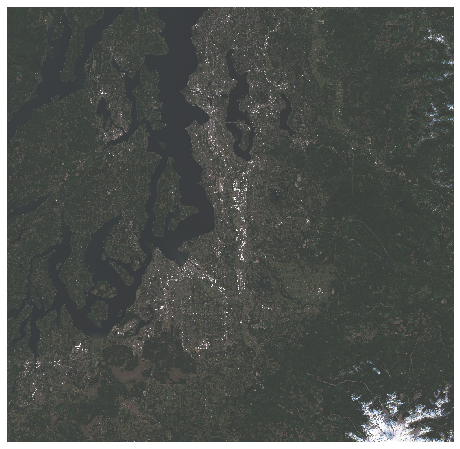

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);

### Monthly composite

Now suppose you don't want to combine images from different parts of the year (for example, you might not want to combine images from January that often include snow with images from July). Again using standard xarray syntax, you can create sets of per-month composites by grouping by month and then computing the median:

In [11]:
monthly = data.groupby("time.month").median().compute()

Convert each of those arrays to a true-color image and plot the results as a grid:

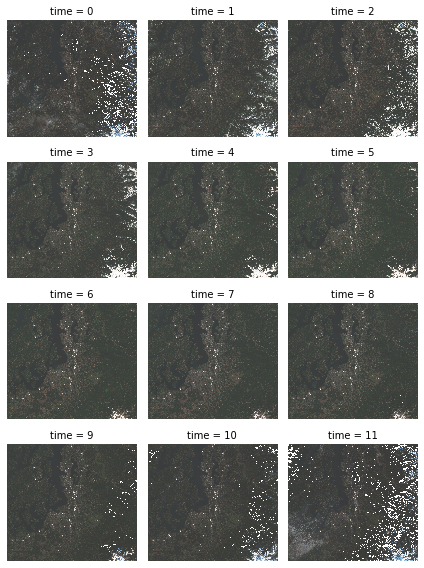

In [12]:
images = [ms.true_color(*x) for x in monthly]
images = xr.concat(images, dim="time")

g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=3, figsize=(6, 8))
for ax in g.axes.flat:
    ax.set_axis_off()

plt.tight_layout()

### Next steps

To learn more about using the Planetary Computer's STAC API, see [Reading data from the STAC API](../quickstarts/reading-stac.ipynb). To learn more about Dask, see [Scaling with Dask](../quickstarts/scale-with-dask.ipynb).

Click on this link to go to the next notebook: [04 Geospatial Classification](04_Geospatial_Classification.ipynb)